This notebook will demonstrate the preprocessing step of converting an attribute with continuous data into a discrete attribute using a variety of binning methods (supervised and unsupervised).

Import Dependencies

In [146]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
import pickle

warnings.filterwarnings('ignore')
np.random.seed(42)

Retrieve Data

In [208]:
df = pd.read_csv('../Dataset/preprocessed_data.csv').iloc[:,1:10]
class_var = df['class']
df.drop('class', axis = 1, inplace=True)
df.head()

,alpha,delta,u,g,r,i,z,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123


In [201]:
df.dtypes

alpha       float64
delta       float64
u           float64
g           float64
r           float64
i           float64
z           float64
class        object
redshift    float64
dtype: object

Let's pick the attribute "u" to complete discretization on.

In [202]:
u = pd.DataFrame(df.u)
u.head()


,u
0,23.87882
1,24.77759
2,25.26307
3,22.13682
4,19.43718


Let's check for outliers.

In [203]:
print((u < 0).sum())

u    0
dtype: int64


There's an outlier we need to remove.

In [204]:
u.nsmallest(1,'u')


,u
54011,14.31105


In [152]:
u = u.drop(index=79543)

In [153]:
u.nsmallest(1,'u')

,u
54011,14.31105


Let's look at the data.

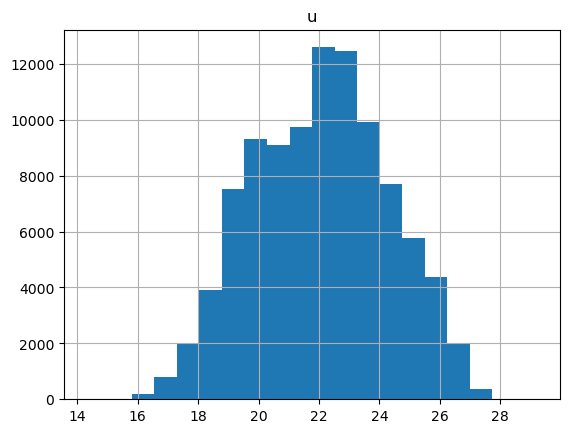

In [154]:
u.hist(bins = 20)
plt.show()

Let's now set up the discretizer so that it uses uniform discretization (bins of same width).

In [155]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

Now let's discretize u.

In [156]:
dc.fit(u)
Xu = dc.transform(u)
print(Xu)

[[6.]
 [7.]
 [7.]
 ...
 [4.]
 [7.]
 [5.]]


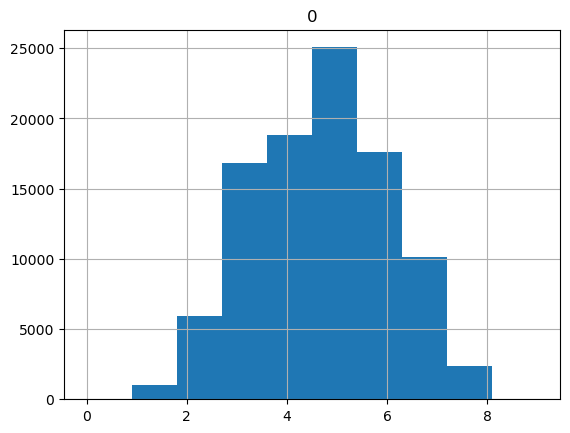

In [157]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins = 10)
plt.show()

In [158]:
print(dc.bin_edges_)

[array([14.31105 , 15.803383, 17.295716, 18.788049, 20.280382, 21.772715,
        23.265048, 24.757381, 26.249714, 27.742047, 29.23438 ])          ]


Time to try with quantile binning. Each bin has the same number of values.

In [159]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile');

In [160]:
dc.fit(u)
Xu = dc.transform(u)
print(Xu)

[[7.]
 [8.]
 [9.]
 ...
 [3.]
 [9.]
 [5.]]


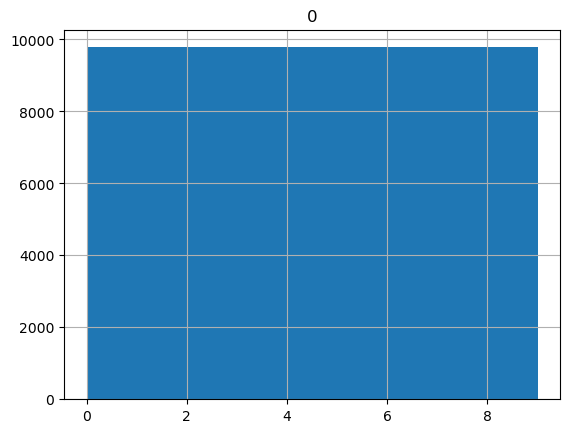

In [161]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins=10)
plt.show()

In [162]:
print(dc.bin_edges_)

[array([14.31105 , 19.119002, 19.949052, 20.721462, 21.528726, 22.15742 ,
        22.72338 , 23.31888 , 24.070266, 25.093166, 29.23438 ])          ]


Finally, let's try kmeans.

In [163]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans');

In [164]:
dc.fit(u)
Xu = dc.transform(u).astype(int)
print(Xu)

[[7]
 [8]
 [8]
 ...
 [4]
 [8]
 [5]]


In [165]:
Xu.astype(int).dtype

dtype('int64')

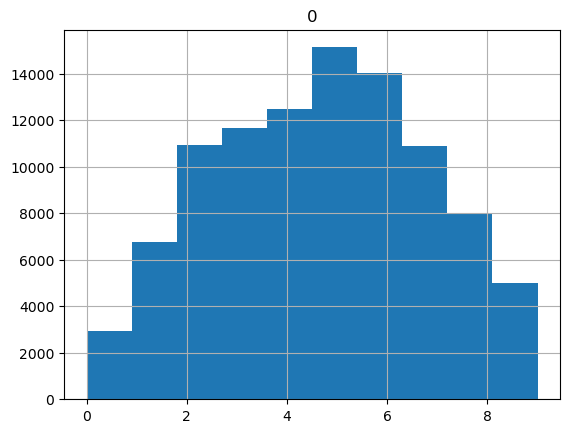

In [166]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins=10)
plt.show()

In [167]:
print(dc.bin_edges_)

[array([14.31105   , 18.01466338, 19.11349395, 20.03590366, 20.98019309,
        21.91386403, 22.79690257, 23.71600339, 24.70441566, 25.7664468 ,
        29.23438   ])                                                   ]


____
# Part2: K-optimization: 
___

In [168]:
print(df.describe())

         Unnamed: 0         alpha  ...             z      redshift
count  97814.000000  97814.000000  ...  97814.000000  97814.000000
mean   49996.045290    177.599567  ...     18.747675      0.521963
std    28871.317609     96.535545  ...      1.737013      0.595197
min        0.000000      0.005528  ...     13.559570     -0.009971
25%    25015.250000    127.478240  ...     17.430633      0.051332
50%    49994.500000    180.868223  ...     18.978620      0.409437
75%    74989.750000    233.890810  ...     19.887667      0.677835
max    99999.000000    359.999810  ...     24.000870      2.768771

[8 rows x 9 columns]


Each of the above techniques will be assessed on each continuous training variable in order to find the best k-value for each variable per discretization technique. Each technique will have an inherent measure for identifying the best k-value for a given variable. Namely, both equal distance and equal frequency will assess optimal-k through evaluation of the sum of each bin's variance, while k-means discretization will assess the optimal-k through the use of a jump statistic that accounts for the relative difference in distortion within bins from one k-value to the next. Ultimately, these optimal bin numbers per technique will be assessed to establish which technique has the most positive impact on the reduction of correlation across the predictive variables. The approach of establishing discretization techniques through direct competition is established in (reference to credit default paper). The approach here focuses on the change in correlation between variables as the desired outcome for discretization rather than focusing on the information gain in order to avoid the potential for over-fitting that is associated with optimizing to the known outcomes (I think the book identifies that this is a danger with supervised discretization but I am hoping to find another peer reviewed source in case the text is not allowed). In addition, this will prevent the preprocessing steps from impacting the training of the data for a particular modeling technique since it is meant to train multiple models using different modeling algorithms.

#### Equal frequency discretization:
The equal frequency technique will use the sum of within-bin variance for each of k-bins in order to choose the best number of bins. Since each bin's object frequency is the same, there is no need for weighing the impact of each bin to the sum. The goal is to identify what k-value produces that smallest variance. 

#### Equal width discretization:
The equal width technique also utilizes variance as a measure for optimum k-bins but in the context of a weighted sum of bin variances for each k-value candidate. The reason for the weights being that the elements in each bin will vary and variance is inversely proportional to the number of instances that inform on it. Since we are using the lack of cumulative variance to establish likeness of each bin (which ideally is high), the membership size of each bin can lead to false implications for the likeness within each bin and extend those implications to the cumulative measure. Therefore, the cumulative measure for the equal width technique is the weighted sum of bin variance. The scalar of each bin variance is the relative frequency of instances in each bin. This results in the bins with the smallest membership level having the largest reduction in contribution to cumulative variance.

#### K-means Discretization:
The k-means technique for discretization measures optimum k-values as the largest jump between the distortion within each identified cluster. Ideally, the clusters will have the lowest possible amount of distortion because they will only contain instances that are more like the other members than the members of other clusters.The distortion can be established using several different techniques, such as the within-cluster sum of squared distances from each cluster's centroid, but in this case our variable space is one dimensional and doesn't need to account for aspects of multivariates spaces. Therefore, the weighted variance of each clustered bin will achieve the equivalent of jump/gap statistics of multivariate spaces.

Collectively all of the binning methods can be evaluated by the same measure to find the best number of bins.
The following helper function achieves this in each instance regardless of whether or not the bins have consistent or variable bin membership. Specifically for equal membership binning the weight will have a constant value 

In [169]:
def wt_sum_variance(df: pd.DataFrame)->float:
    """
        establishes cumulative variance for binning
        of a variable
    """
    # stores weighted variances of bins
    bin_wt_variances = []
    
    # list of bin number identifiers that are to be iterated through to find the weighted variance of each 
    bins = df.iloc[:,1].unique()

    for bin in bins:
        # get bin members
        bin_members = df[df.iloc[:, 1] == bin].iloc[:, 0]
        # appends bin_wt_variances with next value
        bin_wt_variances.append((bin_members.shape[0]/df.shape[0])*bin_members.var())

    return sum(bin_wt_variances)



In [170]:
def sum_entropy(df: pd.DataFrame)-> float:
    bin_entropies = []

    bins = df.iloc[:,1].unique()

    for bin in bins:
        bin_members = df[df.iloc[:,1] == bin]. iloc[:,0]

        p = bin_members.shape[0]/df.shape[0]
        bin_entropies.append(-p*np.log2(p))

    return sum(bin_entropies)

(more)... To establish the location of where the elbow exists, the rate at which the change in variance is i closest to zero is observed. This is achieved from estimates of the 1st and second derivative for the discrete plot ok variance against k as the differences between the differences in variance of k values. in order to identify the optimal k- the location just prior to where the second derivative values change signs is identified. 

In [171]:
def best_k_index_variance(variances: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in variance
    """
    # second derivative of variance
    acceleration = np.diff(np.diff(variances))
    # starting at one corrects for first indicial shift due to diff array 
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] < 0 and acceleration[k] > 0:
            # "+2" addresses second indicial shift
            return k + 2
    return -1  # if no inflection point, return indicator

very similar definition for finding elbow/inflection in the distribution of entropies for k-candidates

In [172]:
def best_k_index_entropy(entropies: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in entropies
    """
    # second derivative of variance
    acceleration = np.diff(np.diff(entropies))
    # starting at one corrects for first indicial shift due to diff array 
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] > 0 and acceleration[k] < 0:
            # "+2" addresses second indicial shift
            return k + 2
    return -1  # if no inflection point, return indicator

sandbox cell:

In [173]:
# var1 = [32, 20, 8, 2, 1.3, 1.2, 1.1]
# best_k_index_variance(var1)

# originally wrote later code in a way where -1 became and index (unintentionally) leading to the last value in the variance list always being returned when an inflection point was not detected. It broke my brain because i couldn't understand where in my code there would be a mechanism that would return the last value in so many instances.

#### K-value candidate range:
The range for candidate k-values tested for each technique is defined to be consistent across all of the binning techniques. The range maximum is determined using the variance and absolute frequency of all instances in the predictive variables. The frequency is inherently constant across variables but the variance is specific to each. The minimum is the number of classes in the predicted variable.

code finds the best k relative to variance inflection point.

In [174]:
# minimum k candidate range
minK = len(df["class"].unique())

# chunks of k candidates to test: prevents running all potential k's if second deriv of variace reveals inflcation point.
chunk = 10

# predictor df
variance_predict_vars = df.columns[df.dtypes == "float64"]
variance_predict_df = df[variance_predict_vars]
variance_predict_df.drop(list(variance_predict_df.filter(regex = 'ID')), axis = 1, inplace = True)

# predictor variables list
colNames = variance_predict_df.columns

for col in colNames:
    x = variance_predict_df[col]

    # ensures that the 
    maxK = min(int(minK * (len(x)//x.var())), 1000)
    print(f"{col}_maxK: {maxK}")
    k_candidates = np.arange(minK,maxK,1, dtype= int)

    # dictionaries: key = k-value, value = labels
    width_dict = defaultdict(list)
    freq_dict = defaultdict(list)
    kmeans_dict = defaultdict(list)

    # lists: store variances for each bin type
    width_variances = []
    freq_variances = []
    kmeans_variances = []

    for i in range(minK, maxK, chunk):

        # protects from out of bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            # discretizer objects per k
            DC_width = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform') 
        
            # populates the dictionaries
            width_dict[k] = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
            
            # creates dfs for variance evaluation
            width_df = pd.DataFrame({'column': x,
                                    'bins': width_dict[k]})

            # populates variance lists
            width_variances.append(wt_sum_variance(width_df))


        best_width_i = best_k_index_variance(width_variances)

        if best_width_i == -1 :
            continue

        best_k_width = k_candidates[best_width_i]
        print(f"{col} width k: {best_k_width}")
        variance_predict_df[f"{col}_width"] = width_dict[best_k_width]

        break

    for i in range(minK, maxK, chunk):

        # protects from outof bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            DC_freq = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile')
        
            # populates the dictionaries
            freq_dict[k] = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

            # creates dfs for variance evaluation
            freq_df = pd.DataFrame({'column': x,
                                    'bins': freq_dict[k]})
            
            # populates variance lists
            freq_variances.append(wt_sum_variance(freq_df))

        best_freq_i = best_k_index_variance(freq_variances)

        if best_freq_i == -1 :
            continue

        
        best_k_freq = k_candidates[best_freq_i]
        print(f"{col} frequency k: {best_k_freq}")
        variance_predict_df[f"{col}_freq"] = freq_dict[best_k_freq]

        break

    for i in range(minK, maxK, chunk):

        # protects from outof bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            DC_kmeans = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='kmeans')
        
            # populates the dictionaries
            kmeans_dict[k] = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

            # creates dfs for variance evaluation
            kmeans_df = pd.DataFrame({'column': x,
                                    'bins': kmeans_dict[k]})
            
            # populates variance lists
            kmeans_variances.append(wt_sum_variance(kmeans_df))

        best_kmeans_i = best_k_index_variance(kmeans_variances)

        if best_kmeans_i == -1 :
            continue

        
        best_k_kmeans = k_candidates[best_kmeans_i]
        print(f"{col} kmeans k: {best_k_kmeans}")
        variance_predict_df[f"{col}_kmeans"] = kmeans_dict[best_k_kmeans]
        
        break


variance_predict_df.head()


alpha_maxK: 30
alpha width k: 8
alpha frequency k: 12
alpha kmeans k: 10
delta_maxK: 759
delta width k: 8
delta frequency k: 11
delta kmeans k: 10
u_maxK: 1000
u width k: 28
u frequency k: 49
u kmeans k: 16
g_maxK: 1000
g width k: 17
g frequency k: 41
g kmeans k: 19
r_maxK: 1000
r width k: 9
r frequency k: 51
r kmeans k: 20
i_maxK: 1000
i width k: 6
i frequency k: 38
i kmeans k: 17
z_maxK: 1000
z width k: 6
z frequency k: 68
z kmeans k: 14
redshift_maxK: 1000
redshift width k: 18
redshift frequency k: 34
redshift kmeans k: 12


,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,alpha_kmeans,delta_width,delta_freq,delta_kmeans,u_width,u_freq,u_kmeans,g_width,g_freq,g_kmeans,r_width,r_freq,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,3,3,4,6,5,17,38,11,10,32,13,5,29,11,3,17,8,3,30,6,4,24,4
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,4,3,3,6,5,19,42,12,11,36,14,6,50,17,4,33,13,4,65,12,5,27,5
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,4,3,4,7,5,20,44,13,11,35,13,5,32,12,3,18,8,3,33,7,4,24,4
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,7,11,8,1,1,1,14,24,8,12,39,16,6,44,15,3,29,11,3,39,7,6,28,5
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,7,11,9,3,5,3,9,6,4,4,3,3,1,2,3,1,1,2,1,2,1,0,11,1


code finds the best k relative to entropy inflection point.

In [175]:
def best_k_index_entropy(entropies: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in entropies
    """
    # second derivative of variance
    acceleration = np.diff(np.diff(entropies))
    # starting at one corrects for first indicial shift due to diff array 
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] > 0 and acceleration[k] < 0:
            # "+2" addresses second indicial shift
            return k + 2
    return np.argmin(acceleration) + 2

In [176]:
# # minimum k candidate range
# minK = len(df["class"].unique())

# # chunks of k candidates to test: prevents running all potential k's if second deriv of variace reveals inflcation point.
# chunk = 10

# # predictor df
# predict_vars = df.columns[df.dtypes == "float64"]
# predict_df = df[predict_vars]
# predict_df.drop(list(predict_df.filter(regex = 'ID')), axis = 1, inplace = True)

# # predictor variables list
# colNames = predict_df.columns

# for col in colNames:
#     x = predict_df[col]

#     # ensures that there are sufficient candidates without being excessive
#     maxK = min(int(minK * (len(x)//x.var())), 1000)
#     print(f"{col}_maxK: {maxK}")
#     k_candidates = np.arange(minK,maxK,1, dtype= int)

#     # dictionaries: key = k-value, value = labels
#     width_dict = defaultdict(list)
#     freq_dict = defaultdict(list)
#     kmeans_dict = defaultdict(list)

#     # lists: store variances for each bin type
#     width_entropies = []
#     freq_entropies = []
#     kmeans_entropies = []

#     for i in range(minK, maxK, chunk):

#         # protects from out of bounds at end of loop range
#         end_i = min(i+chunk, maxK)   

#         for k in range(i, end_i):
            
#             # discretizer objects per k
#             DC_width = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform') 
        
#             # populates the dictionaries
#             width_dict[k] = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
            
#             # creates dfs for variance evaluation
#             width_df = pd.DataFrame({'column': x,
#                                     'bins': width_dict[k]})

#             # populates variance lists
#             width_entropies.append(sum_entropy(width_df))


#         best_width_i = best_k_index_entropy(width_entropies)

#         if best_width_i == -1 :
#             continue

#         best_k_width = k_candidates[best_width_i]
#         print(f"{col} width k: {best_k_width}")
#         predict_df[f"{col}_width"] = width_dict[best_k_width]

#         break

#     for i in range(minK, maxK, chunk):

#         # protects from outof bounds at end of loop range
#         end_i = min(i+chunk, maxK)   

#         for k in range(i, end_i):
            
#             DC_freq = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile')
        
#             # populates the dictionaries
#             freq_dict[k] = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

#             # creates dfs for variance evaluation
#             freq_df = pd.DataFrame({'column': x,
#                                     'bins': freq_dict[k]})
            
#             # populates variance lists
#             freq_entropies.append(sum_entropy(freq_df))

#             # investigative: why really large inflection pts
#             positions = list(range(len(freq_entropies)))
#             plt.scatter(positions, freq_entropies, color='blue')
#             plt.xlabel('Position in list')
#             plt.ylabel('Value')
#             plt.title('Dot Plot of List Values')
#             plt.show()

#         best_freq_i = best_k_index_entropy(freq_entropies)

#         if best_freq_i == -1 :
#             continue

        
#         best_k_freq = k_candidates[best_freq_i]
#         print(f"{col} frequency k: {best_k_freq}")
#         predict_df[f"{col}_freq"] = freq_dict[best_k_freq]

#         break

#     for i in range(minK, maxK, chunk):

#         # protects from outof bounds at end of loop range
#         end_i = min(i+chunk, maxK)   

#         for k in range(i, end_i):
            
#             DC_kmeans = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='kmeans')
        
#             # populates the dictionaries
#             kmeans_dict[k] = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

#             # creates dfs for variance evaluation
#             kmeans_df = pd.DataFrame({'column': x,
#                                     'bins': kmeans_dict[k]})
            
#             # populates variance lists
#             kmeans_entropies.append(sum_entropy(kmeans_df))

#         best_kmeans_i = best_k_index_entropy(kmeans_entropies)

#         if best_kmeans_i == -1 :
#             continue

        
#         best_k_kmeans = k_candidates[best_kmeans_i]
#         print(f"{col} kmeans k: {best_k_kmeans}")
#         predict_df[f"{col}_kmeans"] = kmeans_dict[best_k_kmeans]
        
#         break


# predict_df.head()

In [177]:
# minimum k candidate range
minK = len(df["class"].unique())


# predictor df
entropy_predict_vars = df.columns[df.dtypes == "float64"]
entropy_predict_df = df[entropy_predict_vars]
entropy_predict_df.drop(list(entropy_predict_df.filter(regex = 'ID')), axis = 1, inplace = True)

# predictor variables list
colNames = entropy_predict_df.columns

for col in colNames:
    x = entropy_predict_df[col]

    # ensures that there are sufficient candidates without being excessive
    maxK = min(int(minK * (len(x)//x.var())), 100)
    print(f"{col}_maxK: {maxK}")
    k_candidates = np.arange(minK,maxK,1, dtype= int)

    # dictionaries: key = k-value, value = labels
    width_dict = defaultdict(list)
    freq_dict = defaultdict(list)
    kmeans_dict = defaultdict(list)

    # lists: store variances for each bin type
    width_entropies = []
    freq_entropies = []
    kmeans_entropies = []

     

    for k in range(i, maxK):
            
        # discretizer objects per k
        DC_width = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform') 
        DC_freq = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile')
        DC_kmeans = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='kmeans')
    
        # populates the dictionaries
        width_dict[k] = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
        freq_dict[k] = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
        kmeans_dict[k] = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
        
        # creates dfs for variance evaluation
        width_df = pd.DataFrame({'column': x,
                                'bins': width_dict[k]})
        freq_df = pd.DataFrame({'column': x,
                            'bins': freq_dict[k]})
        kmeans_df = pd.DataFrame({'column': x,
                        'bins': kmeans_dict[k]})

        # populates entropy lists
        width_entropies.append(sum_entropy(width_df))
        freq_entropies.append(sum_entropy(freq_df))
        kmeans_entropies.append(sum_entropy(kmeans_df))


    best_width_i = best_k_index_entropy(width_entropies)
    best_freq_i = best_k_index_entropy(freq_entropies)
    best_kmeans_i = best_k_index_entropy(kmeans_entropies)



    best_k_width = k_candidates[best_width_i]
    best_k_freq = k_candidates[best_freq_i]
    best_k_kmeans = k_candidates[best_kmeans_i]
    

    print(f"{col} width k: {best_k_width}")
    print(f"{col} frequency k: {best_k_freq}")
    print(f"{col} kmeans k: {best_k_kmeans}")


    entropy_predict_df[f"{col}_width"] = width_dict[best_k_width]
    entropy_predict_df[f"{col}_freq"] = freq_dict[best_k_freq]
    entropy_predict_df[f"{col}_kmeans"] = kmeans_dict[best_k_kmeans]



entropy_predict_df.head()

alpha_maxK: 30
alpha width k: 9
alpha frequency k: 5
alpha kmeans k: 10
delta_maxK: 100
delta width k: 9
delta frequency k: 5
delta kmeans k: 11
u_maxK: 100
u width k: 12
u frequency k: 5
u kmeans k: 12
g_maxK: 100
g width k: 6
g frequency k: 5
g kmeans k: 17
r_maxK: 100
r width k: 6
r frequency k: 5
r kmeans k: 7
i_maxK: 100
i width k: 6
i frequency k: 5
i kmeans k: 11
z_maxK: 100
z width k: 7
z frequency k: 5
z kmeans k: 8
redshift_maxK: 100
redshift width k: 15
redshift frequency k: 44
redshift kmeans k: 6


,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,alpha_kmeans,delta_width,delta_freq,delta_kmeans,u_width,u_freq,u_kmeans,g_width,g_freq,g_kmeans,r_width,r_freq,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,1,3,4,3,5,7,3,8,3,3,11,3,2,4,3,2,5,3,2,4,3,31,2
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,1,3,4,3,5,8,4,9,4,4,12,4,4,6,4,4,9,5,4,7,4,35,2
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,1,3,4,3,6,8,4,10,4,4,12,3,3,4,3,2,6,3,2,4,3,32,2
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,8,4,8,1,0,1,6,2,6,4,4,14,4,4,5,3,3,8,3,2,4,5,37,2
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,8,4,9,3,2,4,4,0,2,1,0,3,1,0,0,1,0,1,1,0,0,0,14,0


____
# Part3: Correlation/Mutual Information Optimization for experimental groups
___

The prediction variables are all now represented as a data frame where they are represented as the original continuous data as well as the optimized binning found for each technique based on the variance metrics or mutual information metrics used.

In [178]:
variance_predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,alpha_kmeans,delta_width,delta_freq,delta_kmeans,u_width,u_freq,u_kmeans,g_width,g_freq,g_kmeans,r_width,r_freq,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,3,3,4,6,5,17,38,11,10,32,13,5,29,11,3,17,8,3,30,6,4,24,4
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,4,3,3,6,5,19,42,12,11,36,14,6,50,17,4,33,13,4,65,12,5,27,5
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,4,3,4,7,5,20,44,13,11,35,13,5,32,12,3,18,8,3,33,7,4,24,4
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,7,11,8,1,1,1,14,24,8,12,39,16,6,44,15,3,29,11,3,39,7,6,28,5
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,7,11,9,3,5,3,9,6,4,4,3,3,1,2,3,1,1,2,1,2,1,0,11,1


In [179]:
entropy_predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,alpha_kmeans,delta_width,delta_freq,delta_kmeans,u_width,u_freq,u_kmeans,g_width,g_freq,g_kmeans,r_width,r_freq,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,1,3,4,3,5,7,3,8,3,3,11,3,2,4,3,2,5,3,2,4,3,31,2
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,1,3,4,3,5,8,4,9,4,4,12,4,4,6,4,4,9,5,4,7,4,35,2
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,1,3,4,3,6,8,4,10,4,4,12,3,3,4,3,2,6,3,2,4,3,32,2
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,8,4,8,1,0,1,6,2,6,4,4,14,4,4,5,3,3,8,3,2,4,5,37,2
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,8,4,9,3,2,4,4,0,2,1,0,3,1,0,0,1,0,1,1,0,0,0,14,0


User functions for Mutual Information Matrices generatation: used in test group 1_b and test group 2_b and control_b
* continuous_mi is heuristic and is not restricted to maximum of one. It is only used with the original data to visualize it and compare it to the binned data ensembles

In [180]:
def continuous_mi(df: pd.DataFrame) -> np.ndarray:
    cols = df.columns
    length = len(cols)
    mi_matrix = np.zeros((length, length))

    for i in range(length):
        for j in range(length):

            # conditionally makes diagonals one (simplifies evaluation of change in mi across matrices)
            if i == j:
                mi_matrix[i,j] = 1
            else:
                mi = mutual_info_regression(df[[cols[i]]], df[cols[j]])[0]
                norm_mi = mi/np.sqrt(np.var(df[cols[i]])*np.var(df[cols[j]])) # estimate instead of entropy (which is a pain in continuous data)
                mi_matrix[i,j] = norm_mi

    return mi_matrix

In [181]:
def discrete_mi(df: pd.DataFrame) -> np.ndarray:
    cols = df.columns
    length = len(cols)
    mi_matrix = np.zeros((length, length))

    for i in range(length):
        for j in range(length):
            mi = mutual_info_score(df[cols[i]], df[cols[j]])
           
            norm_mi = mi/np.sqrt(entropy(np.bincount(df[cols[i]]))*entropy(np.bincount(df[cols[j]])))
            mi_matrix[i,j] = norm_mi

    return mi_matrix


### (My proposed) experimental design:


 I think it would be really good to have multiple **test groups**:
 * the results when targeting correlation overall (**Test group A**)
    * group 1_a uses variance to identify k
    * group 2_a uses entropy to identify k

 * <strike>the results when targeting the best correlation reductions in the "problem" variables specifically (**Test group B**)</strike> doesn't vary enough from group A- instead use mutual information measure smallest increase to define (**Test Group B**)
    * group 1_b uses variance to identify k
    * group 2_b uses entropy to identify k

 * a "random" group that doesn't account for any of these metrics and just discretizes on a chosen/random k-value and combination of techniques (**Test group C**)
    * group 1_c uses variance to identify k
    * group 2_c uses entropy to identify k

 Then the **control group** would be:
 * the continuous data (because there is no experimental treatment)
  
The **experimental design**:
* train on each test group, and compare to training on the control group
* let the results be what they are, thats the point of an experiment (I have no attachment to the methodology thats being deployed). 

Outcome:
* the greatest success relative to the control group will determine if (a) discretization matters at all in the efficacy of training different classifier models and (b) if optimization using variance measures has any impact on the efficacy. 

Predetermined hypothesis:
* answers:  do you think discretization will improve on the effectiveness of the models overall and if so do you think the prescribed discretization technique will be more or less effective than random discretization? 

* my take: I tend to think that discretization will be impactful but am starting to anticipate that this particular method of specifying bins may be too dialed to have an impact. <font style: color = "red"> let me know if you want to change this, I am good with that </font>


___
___
Control group prep
___
___

The heat-mapped correlation matrix of the continuous versions of the predictive variables.

In [190]:
# separates continuous predictors from discretized
contPred_df = df.iloc[:,0:8]
contPred_df.to_csv("../Dataset/Control_Group.csv")

var_corr_matrix = contPred_df.corr()

var_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')


,ALPHA_KMEANS,DELTA_KMEANS,U_KMEANS,G_KMEANS,R_KMEANS,I_KMEANS,Z_KMEANS,REDSHIFT_KMEANS
ALPHA_KMEANS,1.000,0.134,-0.004,-0.022,-0.032,-0.033,-0.033,-0.005
DELTA_KMEANS,0.134,1.000,-0.028,-0.010,-0.007,-0.001,0.002,0.042
U_KMEANS,-0.004,-0.028,1.000,0.850,0.711,0.586,0.523,0.217
G_KMEANS,-0.022,-0.010,0.850,1.000,0.923,0.821,0.757,0.421
R_KMEANS,-0.032,-0.007,0.711,0.923,1.000,0.958,0.916,0.536
I_KMEANS,-0.033,-0.001,0.586,0.821,0.958,1.000,0.972,0.581
Z_KMEANS,-0.033,0.002,0.523,0.757,0.916,0.972,1.000,0.578
REDSHIFT_KMEANS,-0.005,0.042,0.217,0.421,0.536,0.581,0.578,1.000


___
___
Test group 1 prep
___
___

### Test Group 1 consists of data frames of optimized discretizations of continuous predictive variables. The number of bins is based on variance measures. The bin type ensembles are based on both reduction of correlation across variables (1_a) and reduction of mutual information across variables (1_b). Both correlation and mutual information measure the level of dependency between variables but correlation reveals variation that is linear only while mutual information can have relationships that are nonlinear as well as linear

### Test Group 1_a

Based in variance metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through correlation reduction.

In [183]:
# separate original discretized predictors from continuous
var_discPred_df = variance_predict_df.iloc[:,8:variance_predict_df.shape[1]]

# strips the variable identifier from the matrix
var_corr_matrix = var_corr_matrix.values

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contVar_names = contPred_df.columns

discVar_names = list(var_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discVar_names[i:i+3] for i in range(0,len(discVar_names),3)]

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:
                                group_names = [a,d,u,g,r,i,z,red]
                                df = var_discPred_df[group_names]
                                df_cols = df.columns
                                # print(df.head(3))
                                disc_cor_mat = df.corr().values
                                # messed up commented line below: should be final - initial 
                                # diffCor_mat = -(corr_matrix - cor_mat)
                                diffCor_mat = -(disc_cor_mat - var_corr_matrix)
                                # print(diffCor_mat)
                                summed_corDiff = np.sum(diffCor_mat)
                                # print(cumm_diffCor)
                                obj = {
                                      'variable_names' : df_cols,
                                    #   'df' : df,
                                      'cor_mat' : disc_cor_mat,
                                      'diffCor_mat' : diffCor_mat,
                                      'summed_corDiff' : summed_corDiff
                                    }
                                mosaics_list.append(obj)

                     

  # transform df into cor matrix
  # find and store difference between the continuous corr matrix and the mosaic cor matrix as well as cumulative absolute distance
  # order the mosaic dfs by greatest to least cumulative cor distance

Gets the combinations of the optimized discretized variables that reduce the correlation the to the greatest degree and the the combination that actually increases the overall correlation.

In [184]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_corDiff"])

CorChange_best_df = var_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]
# CorChange_worst_df = discPred_df[sorted_mosaics_list[0]['variable_names']]

CorChange_best_df.head()

# Creates Test Group 1 df
CorChange_best_df.to_csv("../Dataset/TestGroup_1a.csv")

visualizes the best correlation reduction from binning technique ensemble

In [ ]:
best_df_corr_matrix = CorChange_best_df.corr()

best_df_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

,ALPHA_FREQ,DELTA_KMEANS,U_WIDTH,G_FREQ,R_FREQ,I_WIDTH,Z_WIDTH,REDSHIFT_WIDTH
ALPHA_FREQ,1.000,0.130,-0.007,-0.027,-0.035,-0.032,-0.033,-0.004
DELTA_KMEANS,0.130,1.000,-0.028,-0.015,-0.002,-0.006,-0.004,0.045
U_WIDTH,-0.007,-0.028,1.000,0.836,0.683,0.594,0.529,0.145
G_FREQ,-0.027,-0.015,0.836,1.000,0.909,0.787,0.725,0.320
R_FREQ,-0.035,-0.002,0.683,0.909,1.000,0.916,0.881,0.485
I_WIDTH,-0.032,-0.006,0.594,0.787,0.916,1.000,0.941,0.528
Z_WIDTH,-0.033,-0.004,0.529,0.725,0.881,0.941,1.000,0.528
REDSHIFT_WIDTH,-0.004,0.045,0.145,0.320,0.485,0.528,0.528,1.000


In [137]:
# min_df_corr_matrix = CorChange_min_df.corr()

# min_df_corr_matrix.style\
#     .format(precision = 3)\
#     .format_index(str.upper, axis = 0)\
#     .format_index(str.upper, axis = 1)\
#     .background_gradient(cmap='coolwarm')

### Test Group 1_b

Based in variance metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through mutual information reduction.

In [86]:
test_df = variance_predict_df.iloc[:,[8,11,14,17,20]]

print(test_df.head())

discrete_mi(test_df)

   alpha_width  delta_width  u_width  g_width  r_width
0            3            4       17       10        5
1            3            3       19       11        6
2            3            4       20       11        5
3            7            1       14       12        6
4            7            3        9        4        1


array([[1.        , 0.12454808, 0.00762735, 0.01234982, 0.01719893],
       [0.12454808, 1.        , 0.00376838, 0.00549696, 0.00833369],
       [0.00762735, 0.00376838, 1.        , 0.31583494, 0.22122235],
       [0.01234982, 0.00549696, 0.31583494, 1.        , 0.45679059],
       [0.01719893, 0.00833369, 0.22122235, 0.45679059, 1.        ]])

In [ ]:
# separate original discretized predictors from continuous
var_discPred_df = variance_predict_df.iloc[:,8:variance_predict_df.shape[1]]

# creates continuous mutual information matrix
var_mi_matrix = continuous_mi(contPred_df)
print(var_mi_matrix)

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contVar_names = contPred_df.columns

discVar_names = list(var_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discVar_names[i:i+3] for i in range(0,len(discVar_names),3)]

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:

                                group_names = [a,d,u,g,r,i,z,red]
                                df = var_discPred_df[group_names]
                                df_cols = df.columns

                                # creates mutual info matrix for current group
                                disc_mi_mat = discrete_mi(df)
                                diff_mi_mat = -(disc_mi_mat - var_mi_matrix)
                                summed_diff_mi = np.sum(diff_mi_mat)
                                print(summed_diff_mi)
                                obj = {
                                      'variable_names' : df_cols,
                                      'mi_mat' : disc_mi_mat,
                                      'diff_mi_mat' : diff_mi_mat,
                                      'summed_diff_mi' : summed_diff_mi
                                    }
                                mosaics_list.append(obj)


In [131]:
mi_mosaics_copy = mosaics_list.copy()

# don't want to run the above cell ever again:
with open('../Dataset/mi_mosaics_variance.pkl', 'wb') as f:
    pickle.dump(mi_mosaics_copy, f)

In [118]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_diff_mi"])

miChange_best_df = var_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]
# CorChange_worst_df = discPred_df[sorted_mosaics_list[0]['variable_names']]


# Creates Test Group 1 df
miChange_best_df.to_csv("../Dataset/TestGroup_1b.csv")

In [117]:
cols = miChange_best_df.columns

best_df_mi_matrix = pd.DataFrame(discrete_mi(miChange_best_df), index= cols, columns=cols)
best_df_mi_matrix

best_df_mi_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

,ALPHA_FREQ,DELTA_FREQ,U_FREQ,G_FREQ,R_FREQ,I_FREQ,Z_FREQ,REDSHIFT_FREQ
ALPHA_FREQ,1.000,0.096,0.005,0.007,0.009,0.008,0.007,0.018
DELTA_FREQ,0.096,1.000,0.003,0.004,0.007,0.006,0.005,0.008
U_FREQ,0.005,0.003,1.000,0.232,0.149,0.132,0.114,0.115
G_FREQ,0.007,0.004,0.232,1.000,0.339,0.278,0.227,0.167
R_FREQ,0.009,0.007,0.149,0.339,1.000,0.444,0.322,0.167
I_FREQ,0.008,0.006,0.132,0.278,0.444,1.000,0.476,0.176
Z_FREQ,0.007,0.005,0.114,0.227,0.322,0.476,1.000,0.164
REDSHIFT_FREQ,0.018,0.008,0.115,0.167,0.167,0.176,0.164,1.000


### Test group 1_c: 
Random selection of number of bins and binning techniques for transformation of each continuous predictive variable. 

In [218]:
kmin = 3
kmax = 60
varNames = df.columns

randomPredict_df = pd.DataFrame()

for var in varNames:
        choice = np.random.randint(1,4)
        x = df[var]
        if choice == 1:
                DC_width = KBinsDiscretizer(n_bins=np.random.randint(kmin,kmax+1), encode='ordinal', strategy='uniform')
                discVar = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
                randomPredict_df[f"{var}_width"] = discVar
                 
        elif choice == 2:
                DC_freq = KBinsDiscretizer(n_bins=np.random.randint(kmin,kmax+1), encode='ordinal', strategy='quantile')
                discVar = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
                randomPredict_df[f"{var}_freq"] = discVar
        else:
                DC_kmeans = KBinsDiscretizer(n_bins=np.random.randint(kmin,kmax+1), encode='ordinal', strategy='kmeans')
                discVar = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
                randomPredict_df[f"{var}_kmeans"] = discVar

randomPredict_df.to_csv("../Dataset/TestGroup_1c.csv")

In [219]:
randomPredict_df.head()

,alpha_kmeans,delta_kmeans,u_width,g_kmeans,r_freq,i_kmeans,z_kmeans,redshift_width
0,5,14,10,18,8,16,25,7
1,6,14,11,20,14,25,40,9
2,5,15,12,19,9,17,26,8
3,14,4,8,23,13,22,27,11
4,15,11,5,5,0,5,9,1


___
___
Test group 2 prep
___
___

Sandbox cell: Identifies dynamically the continuous variables with the highest correlation (> .90)

In [48]:
# n = corr_matrix.shape[0]
# var_names = contVar_names
# high_corr_pair_idx = []

# temp_corr_matrix = corr_matrix.copy()
# temp_corr_matrix[temp_corr_matrix == 1] = 0
# temp_corr_matrix = pd.DataFrame(temp_corr_matrix, columns = var_names, index= var_names)
# print(temp_corr_matrix)
# # print(temp_corr_matrix)
# for i in range(n):
#     for j in range(n):
#         if abs(temp_corr_matrix.iloc[i,j]) > .90:
#             high_corr_pair_idx.append((i,j))

# print(high_corr_pair_idx)

In [ ]:
# separate original discretized predictors from continuous
discPred_df = predict_df.iloc[:,8:predict_df.shape[1]] # performed above cell


# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contVar_names = contPred_df.columns # performed above cell

# generates list of highly correlated variable pairs
n = corr_matrix.shape[0]
var_names = contVar_names
high_corr_pair_idx = []

temp_corr_matrix = corr_matrix.copy()
temp_corr_matrix[temp_corr_matrix == 1] = 0
temp_corr_matrix = pd.DataFrame(temp_corr_matrix, columns = var_names, index= var_names)
for i in range(n):
    for j in range(n):
        if abs(temp_corr_matrix.iloc[i,j]) > .90:
            high_corr_pair_idx.append((i,j))


discVar_names = list(discPred_df.columns) # generated above cell

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discVar_names[i:i+3] for i in range(0,len(discVar_names),3)] # generated above cell

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:
                                summed_corDiff = 0

                                group_names = [a,d,u,g,r,i,z,red]
                                df = discPred_df[group_names]

                                df_cols = df.columns
                                # print(df.head(3))
                                disc_cor_mat = df.corr().values
                                

                                for pair in high_corr_pair_idx:
                                    summed_corDiff += -(disc_cor_mat[pair[0], pair[1]] - corr_matrix[pair[0], pair[1]])

                            
                                obj = {
                                      'variable_names' : df_cols,
                                      'cor_mat' : disc_cor_mat,
                                      'diffCor_mat' : diffCor_mat,
                                      'summed_corDiff' : summed_corDiff
                                    }
                                mosaics_list.append(obj)

                     

  # transform df into cor matrix
  # find and store difference between the continuous corr matrix and the mosaic cor matrix as well as cumulative absolute distance
  # order the mosaic dfs by greatest to least cumulative cor distance

In [ ]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_corDiff"])

CorChange_best_df = discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]

# Creates Test Group 2 df
CorChange_best_df.to_csv("../Dataset/TestGroup2.csv")

In [154]:
best_df_corr_matrix = CorChange_best_df.corr()

best_df_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

,ALPHA_KMEANS,DELTA_KMEANS,U_KMEANS,G_FREQ,R_WIDTH,I_WIDTH,Z_FREQ,REDSHIFT_KMEANS
ALPHA_KMEANS,1.000,0.134,-0.004,-0.024,-0.030,-0.029,-0.032,-0.005
DELTA_KMEANS,0.134,1.000,-0.028,-0.015,-0.006,-0.006,0.009,0.042
U_KMEANS,-0.004,-0.028,1.000,0.840,0.716,0.595,0.498,0.217
G_FREQ,-0.024,-0.015,0.840,1.000,0.896,0.787,0.723,0.401
R_WIDTH,-0.030,-0.006,0.716,0.896,1.000,0.917,0.893,0.528
I_WIDTH,-0.029,-0.006,0.595,0.787,0.917,1.000,0.930,0.560
Z_FREQ,-0.032,0.009,0.498,0.723,0.893,0.930,1.000,0.588
REDSHIFT_KMEANS,-0.005,0.042,0.217,0.401,0.528,0.560,0.588,1.000


___
___
Alt. Test group 2 prep
___
___

Shows all versions of each discretized predictive variable

In [95]:
entropy_predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,alpha_kmeans,delta_width,delta_freq,delta_kmeans,u_width,u_freq,u_kmeans,g_width,g_freq,g_kmeans,r_width,r_freq,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,1,3,4,3,5,7,3,8,3,3,11,3,2,4,3,2,5,3,2,4,3,31,2
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,1,3,4,3,5,8,4,9,4,4,12,4,4,6,4,4,9,5,4,7,4,35,2
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,1,3,4,3,6,8,4,10,4,4,12,3,3,4,3,2,6,3,2,4,3,32,2
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,8,4,8,1,0,1,6,2,6,4,4,14,4,4,5,3,3,8,3,2,4,5,37,2
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,8,4,9,3,2,4,4,0,2,1,0,3,1,0,0,1,0,1,1,0,0,0,14,0


### Test Group 2_a

Based in entropy metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through correlation reduction.

In [126]:
# separate original discretized predictors from continuous
ent_discPred_df = entropy_predict_df.iloc[:,8:entropy_predict_df.shape[1]]
ent_contPred_df = entropy_predict_df.iloc[:,0:8]

# strips the variable identifier from the matrix
ent_corr_matrix = var_corr_matrix.values

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contEnt_names = ent_contPred_df.columns

discEnt_names = list(ent_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discEnt_names[i:i+3] for i in range(0,len(discEnt_names),3)]

ent_mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:
                                group_names = [a,d,u,g,r,i,z,red]
                                df = ent_discPred_df[group_names]
                                df_cols = df.columns
                                disc_cor_mat = df.corr().values

                                diffCor_mat = -(disc_cor_mat - ent_corr_matrix)
                                summed_corDiff = np.sum(diffCor_mat)
                                
                                obj = {
                                      'variable_names' : df_cols,
                                      'cor_mat' : disc_cor_mat,
                                      'diffCor_mat' : diffCor_mat,
                                      'summed_corDiff' : summed_corDiff
                                    }
                                
                                ent_mosaics_list.append(obj)

                     

  # transform df into cor matrix
  # find and store difference between the continuous corr matrix and the mosaic cor matrix as well as cumulative absolute distance
  # order the mosaic dfs by greatest to least cumulative cor distance

In [124]:
sorted_mosaics_list = sorted(ent_mosaics_list, key = lambda x: x["summed_corDiff"])

corChange_best_df = ent_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]
# CorChange_worst_df = discPred_df[sorted_mosaics_list[0]['variable_names']]

# Creates Test Group 1 df
corChange_best_df.to_csv("../Dataset/TestGroup_2a.csv")

In [125]:
best_df_corr_matrix = CorChange_best_df.corr()

best_df_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

,ALPHA_WIDTH,DELTA_WIDTH,U_KMEANS,G_WIDTH,R_WIDTH,I_WIDTH,Z_WIDTH,REDSHIFT_KMEANS
ALPHA_WIDTH,1.000,0.131,-0.001,-0.015,-0.025,-0.025,-0.026,-0.004
DELTA_WIDTH,0.131,1.000,-0.020,0.002,0.002,0.001,0.003,0.047
U_KMEANS,-0.001,-0.020,1.000,0.850,0.716,0.595,0.529,0.217
G_WIDTH,-0.015,0.002,0.850,1.000,0.916,0.816,0.755,0.429
R_WIDTH,-0.025,0.002,0.716,0.916,1.000,0.917,0.882,0.528
I_WIDTH,-0.025,0.001,0.595,0.816,0.917,1.000,0.941,0.560
Z_WIDTH,-0.026,0.003,0.529,0.755,0.882,0.941,1.000,0.553
REDSHIFT_KMEANS,-0.004,0.047,0.217,0.429,0.528,0.560,0.553,1.000


### Test Group 2_b

Based in entropy metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through mutual information reduction.

In [129]:
# separate original discretized predictors from continuous
ent_discPred_df = entropy_predict_df.iloc[:,8:entropy_predict_df.shape[1]]

# creates continuous mutual information matrix
ent_mi_matrix = continuous_mi(contPred_df)
print(ent_mi_matrix)

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contEnt_names = contPred_df.columns

discEnt_names = list(ent_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discEnt_names[i:i+3] for i in range(0,len(discEnt_names),3)]

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:

                                group_names = [a,d,u,g,r,i,z,red]
                                df = ent_discPred_df[group_names]
                                df_cols = df.columns

                                # creates mutual info matrix for current group
                                disc_mi_mat = discrete_mi(df)
                                diff_mi_mat = -(disc_mi_mat - ent_mi_matrix)
                                summed_diff_mi = np.sum(diff_mi_mat)
                                print(summed_diff_mi)
                                obj = {
                                      'variable_names' : df_cols,
                                      'mi_mat' : disc_mi_mat,
                                      'diff_mi_mat' : diff_mi_mat,
                                      'summed_diff_mi' : summed_diff_mi
                                    }
                                mosaics_list.append(obj)

[[1.00000000e+00 3.84964268e-02 1.28183702e-03 1.84340968e-03
  2.30866458e-03 1.92722125e-03 1.49822565e-03 3.11326836e-03]
 [3.91419625e-02 1.00000000e+00 5.52768848e-04 1.31497869e-03
  1.46107441e-03 2.20536886e-03 1.92513441e-03 1.93015149e-03]
 [1.10938622e-03 8.73351081e-04 1.00000000e+00 5.71811317e-02
  3.55466974e-02 3.37708574e-02 3.62032219e-02 3.53305832e-02]
 [1.27388097e-03 1.13229029e-03 5.73517582e-02 1.00000000e+00
  6.87032788e-02 6.06033486e-02 6.17596302e-02 4.46129500e-02]
 [2.39638402e-03 1.03806301e-03 3.56051726e-02 6.83537894e-02
  1.00000000e+00 9.07622649e-02 8.45478601e-02 4.43490350e-02]
 [1.78753834e-03 1.95774407e-03 3.36687545e-02 6.05753755e-02
  9.09948041e-02 1.00000000e+00 1.31770642e-01 5.14107974e-02]
 [1.69180246e-03 1.83030734e-03 3.63306655e-02 6.18134463e-02
  8.45373223e-02 1.32033928e-01 1.00000000e+00 6.04781232e-02]
 [2.31692655e-03 2.61437071e-03 3.53573232e-02 4.43717168e-02
  4.43148616e-02 5.10858357e-02 6.06927896e-02 1.00000000e+00]]

In [221]:
mi_mosaics_copy = mosaics_list.copy()

# don't want to run the above cell ever again either:
with open('../Dataset/mi_mosaics_entropy.pkl', 'wb') as f:
    pickle.dump(mi_mosaics_copy, f)

In [132]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_diff_mi"])

miChange_best_df = var_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]
# CorChange_worst_df = discPred_df[sorted_mosaics_list[0]['variable_names']]


# Creates Test Group 1 df
miChange_best_df.to_csv("../Dataset/TestGroup_2b.csv")

### Test Group 2_c: intentionally the same as 1_c

In [220]:
randomPredict_df.to_csv("../Dataset/TestGroup_2c.csv")